# Dice Battle, un jeu à deux joueurs

Le jeu sera bientôt doublé d'une interface graphique propre.  
Pour l'instant, on se contente d'une implémentation analytique.

In [1]:
# Partie calculatoire 
import numpy as np
import random
import time
from pulp import *
import matplotlib.pyplot as plt

## >>> _Invariants du jeu_

La pensée stratégique dépendra dans tous les cas des calculs probabilistes définis dans la première partie du rapport :

In [2]:
class Strategy(object):
    
    # ******************************************** ENVISAGER UNE PARTIE *******************************************************
    def __init__(self,N,D):
        
        # Paramètres de la partie : objectif de points, nombre de dés autorisés -----------------------------------------------
        self.N = N
        self.D = D
        # ---------------------------------------------------------------------------------------------------------------------
        
        # Tables de stockage pour la programmation dynamique ------------------------------------------------------------------
        self.MQ = np.ones((self.D+1,self.N+6*self.D))*np.inf 
        # MQ contiendra les Q(d,k), 
        # soit les probabilités de réaliser chaque valeur de score atteignable - hormis 1
        # pour toutes les quantités de dés possibles.
        self.MP = np.ones((self.D+1,self.N+6*self.D))*np.inf
        # MP contiendra les P(d,k),
        # c'est une version de MQ qui prend aussi en compte la possibilité d'obtenir 1.
        # Elle est l'acteur fondateur des prises de décision.
        
        # MP et MQ servent aux premières phases des calculs, elles ont été créées par... purisme ? 
        # En termes d'optimisation, elles ne sont pas aussi utiles que self.MEG dans le jeu séquentiel. 
        # ---------------------------------------------------------------------------------------------------------------------
        
    # *************************************************************************************************************************
    
    
    # ********************************* METHODES COMMUNES A TOUTES LES VARIANTES **********************************************
    
    # Réfléchir en partant d'une étude probabiliste, en particulier des chances de réalisation de chaque score. ---------------
    def Q(self,d,k):
        """ Probabilité d'obtenir k points en lançant d dés, sachant qu'on n'a pas obtenu de 1. """
        if k < 2*d or k > 6*d:                                  # cas de base : scores inatteignables
            return 0                         
        if d == 1:                                              # cas de base : 1 chance sur 5 d'avoir 2, 3, 4, 5 ou 6 à un dé
            return 1/5                                   
        if self.MQ[d,k] != np.inf:                              # récupérer la valeur de Q si elle existe déjà ?
            return self.MQ[d,k]         
        p = np.array([self.Q(d-1,k-j) for j in range(2,7)])     # sinon, la calculer et la stocker 
        self.MQ[d,k] = np.sum(p)/5
        return self.MQ[d,k]

    def P(self,d,k):
        """ Probabilité d'obtenir k points en lançant d dés - tout court. """
        if k > 1 and k < 2*d or k > 6*d+1:                      # cas de base : scores inatteignables
            return 0             
        if k == 1:                                              # cas de base : probabilité d'obtenir 1 quel que soit d
            return 1-(5/6)**d                            
        if self.MP[d,k] != np.inf:                              # récupérer la valeur de P si elle existe déjà ?
            return self.MP[d,k]         
        self.MP[d,k] = (5/6)**d * self.Q(d,k)                   # sinon, la calculer et la stocker
        return self.MP[d,k]
    
    def allP(self):
        """ La fonction précédente ne calcule qu'une seule case de la matrice P(d,k).
        On s'assure ci-dessous, comme requis en 1), qu'elles se remplissent toutes. """
        for k in range (1,self.N+6*self.D):
            for d in range(1,self.D+1):
                self.MP[d,k] = self.P(d,k)
    # -------------------------------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************************************

Le décor général est posé.  
On peut maintenant choisir entre les deux variantes du jeu : séquentiel ? simultané ?

## >>> _Variante séquentielle_

La variante séquentielle contient deux méthodes majeures, un choix entre la stratégie aveugle et la stratégie optimale (avec en bonus la stratégie aléatoire). Ci-dessous, la classe qui permet de créer et d'utiliser le socle de décision adapté.

In [3]:
class Sequential(Strategy):
    
    # **************************************** DEFINIR UNE PARTIE EN MODE SEQUENTIEL ******************************************
    def __init__(self,N,D):
        
        # charger les méthodes générales, N, D et tout ce qui s'ensuit de matrices de probabilité
        Strategy.__init__(self,N,D) 
        
        # Tables de stockage pour la programmation dynamique ------------------------------------------------------------------
        self.MEG = np.ones((self.N+1,self.N+6*self.D))*np.inf
        self.MEG[self.N-1:,:] = 1
        self.MEG[:self.N,self.N:] = -1
        # MEG stocke les espérances de gain d'un joueur en toute situation,
        # à savoir, quel que soit son score actuel (indice i) et celui de son adversaire (indice j).
        # Les scores en question peuvent théoriquement atteindre N+6D-1 si l'on arrive près de N et que l'on joue encore. 
        # Ce qu'implique la séquentialité, c'est que ce dépassement de N ne peut arriver que pour un seul des adversaires, 
        # après quoi l'autre cesse de jouer. On se permet donc de réduire l'une des deux dimensions de la matrice à N.
        self.star = np.zeros((self.N,self.N)).astype('int')
        # star stockera les réponses optimales des joueurs, celles qui maximisent l'espérance de gain en chaque situation.
        # En mode stratégie optimale, c'est immédiatement à partir de star que le joueur décide de jouer un coup.
        # ---------------------------------------------------------------------------------------------------------------------
        
        # Variables d'état ----------------------------------------------------------------------------------------------------
        self.emptyE = True
        # emptyE représente l'état de MEG : a-t-elle déjà été calculée ? 
        # Si oui, le calcul étant chronophage, on évitera de le refaire pour les parties suivantes sous un même N et D.
        # ---------------------------------------------------------------------------------------------------------------------

        
    # ************************************************ STRATEGIE AVEUGLE ******************************************************
    
    # Un choix paresseux : chercher à obtenir immédiatement un maximum de points. ---------------------------------------------

    def scoremax(self):
        """ Retourne le nombre de dés maximisant l'espérance du nombre de points 
        en fonction du nombre maximal de dés autorisés. """
        d = np.arange(self.D) + 1
        ep = 4*d*(5/6)**d + 1 - (5/6)**d
        return np.argmax(ep) + 1
    
    def blind_strategy(self,i,j):
        """ Il suffit alors de toujours jouer la même chose. """
        return self.scoremax()
    
    # -------------------------------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************************************
    
    
    # *********************************************** STRATEGIE OPTIMALE ******************************************************
    
    # Grâce aux calculs de probabilités, on arrive à une stratégie plus intelligente : ----------------------------------------
    # l'idée est maintenant d'adapter ses choix à la situation, notamment à proximité de N. -----------------------------------

    def eg(self,i,j):
        """ Calcul de l'espérance de gain du joueur 1. 
        Implique de modéliser tous les chemins possibles jusqu'à la victoire... """
        if self.MEG[i,j] != np.inf: 
            return self.MEG[i,j]                                # optimisation du temps de calcul par mémoïsation
        mesesp = []                                                              
        sesesp = []                                             # (on en profite pour regarder l'EG de l'adversaire)
        
        for d in range(1,self.D+1):                             # pour tous les choix de d possibles
            monesp = 0
            sonesp = 0
            for k in range(1,6*d+1):                            # calculer l'espérance de gain (considérer tout score possible)
                monesp += self.MP[d,k]* self.eg(j,i+k)          # MP a été hérité de la classe mère Strategie
                sonesp += self.MP[d,k] * self.eg(i,j+k) 
            mesesp.append(-monesp)
            sesesp.append(-sonesp)
            
        self.MEG[i,j] = np.amax(mesesp)                         # on ne retient que l'espérance maximale sur les d possibles
        self.star[i,j] = np.argmax(mesesp)+1                    # on a ainsi trouvé le d* de la stratégie optimale
        self.MEG[j,i] = np.amax(sesesp)                         # gain de temps : raisonnement symétrique en face de la diagonale
        self.star[j,i] = np.argmax(sesesp)+1
        return self.MEG[i,j]
                
    def allEG(self):
        """ La fonction précédente est cantonnée à des paramètres (i,j) fixés. 
        S'assurer que MEG soit complète avant de jouer. """
        self.allP()                                             # une fois tous les P calculés
        for i in range(self.N-1,-1,-1): 
            for j in range(self.N-1,-1,-1):
                self.eg(i,j)                                    # lancer le calcul d'EG pour tous les i et j
    
    def optimal_strategy(self,i,j):
        """ ... et la décision peut enfin être prise. """
        if self.emptyE:                                         # faire en sorte que MEG soit calculée une et une seule fois
            self.allEG()                              
            self.emptyE = False
        if i==self.N-1 and j==self.N-1: return 1                # éviter les "suicides" juste avant l'arrivée : toujours jouer 1
        return self.star[i,j]                                   # à un stade donné, agir de sorte à maximiser l'espérance
    
    # -------------------------------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************************************
    
    
    # *********************************************** STRATEGIE ALEATOIRE *****************************************************
    
    # Défi : trouver un mode de jeu encore plus absurde que la stratégie aveugle. ---------------------------------------------
    def random_strategy(self,i,j):
        return random.randint(1,self.D)
    
    # -------------------------------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************************************

## >>> _Variante simultanée_

La variante simultanée va compter sur un package de programmation linéaire, PULP.

In [22]:
class Simultaneous(Strategy):
    
    # ************************************** DEFINIR UNE PARTIE EN MODE SIMULTANE *********************************************
    def __init__(self,N,D):
        
        # charger les méthodes générales, N, D et tout ce qui s'ensuit de matrices de probabilité -----------------------------
        Strategy.__init__(self,N,D)   
        # ---------------------------------------------------------------------------------------------------------------------
        
        # Pour l'instant, personne n'a calculé sa stratégie optimale. ---------------------------------------------------------
        self.clear = True 
        self.p = np.zeros((self.D))
        # ---------------------------------------------------------------------------------------------------------------------

        # CECI N'EST UTILE QUE POUR LA PARTIE OPTIONNELLE
        # Tables de stockage pour la programmation dynamique ------------------------------------------------------------------
        self.MEG = np.ones((self.N+6*self.D,self.N+6*self.D))*np.inf
        self.MEG[self.N:,:] = 1
        self.MEG[:self.N,self.N:] = -1
        self.star = np.zeros((self.N,self.N)).astype('int')
        self.emptyE = True
        # Ce code est presque identique à celui qu'on trouve dans Sequential.
        # Il n'a pas été factorisé dans la classe mère en raison de l'aspect facultatif de son traitement.
        # ---------------------------------------------------------------------------------------------------------------------
        
    # *************************************************************************************************************************
        
        
    # ***************************************** OPTIMISATION DU JEU EN UN COUP ************************************************
    
    # Partie 1 : se représenter la situation, commencer par un calcul d'espérances du point de vue d'un des joueurs. ----------

    def eg1(self,d1,d2):
        """ Retourne l'espérance de gain du joueur 1, qui joue d1 dés. 
        Le joueur 2 joue d2 dés, il ne le voit pas : les deux joueurs jouent en même temps et une seule fois. """
        res = 0
        # Probabilité que le joueur 1 obtienne plus de points que le joueur 2 ?
        for k in range(1,6*d1+1):
            temp = 0
            for l in range(1,k):
                temp += self.P(d2,l)
            res += self.P(d1,k)*temp
        # On soustrait la probabilité que le joueur 2 obtienne plus de points que le joueur 1.
        for k in range(1,6*d2+1):
            temp = 0
            for l in range(1,k):
                temp += self.P(d1,l)
            res -= self.P(d2,k)*temp
        return res
   
    def gain_matrix(self):
        """ Obtenir la matrice des espérances de gain du joueur 1, calculée avec la fonction eg1. """
        M = np.zeros((self.D,self.D))
        for i in range(self.D):
            for j in range(self.D):
                M[i,j] = self.eg1(i+1,j+1)
        return M
    
    # -------------------------------------------------------------------------------------------------------------------------
    
    # Partie 2 : le joueur 1 est désormais capable de créer sa stratégie en résolvant un programme linéaire. ------------------
    
    def solve_pl(self):
        """ Renvoyer le vecteur correspondant à la stratégie du premier joueur.
        Le PL correspondant est défini dans le rapport. """
        prob = LpProblem("Jeu en un coup", LpMaximize) 
        # Créer les variables p1, p2, ..., pD
        var = [LpVariable("p%d" % i, lowBound=0, cat='Continuous') for i in range(1,self.D+1)]
        # L'objectif est la somme des pi.
        prob += lpSum(var)  
        
        eg = self.gain_matrix()
        # Pour chaque colonne de eg, ajouter la contrainte z - transposée_de_p * colonne_de_eg <= 0 au problème.
        for j in range(self.D): 
            l = []
            for i in range(self.D):
                l.append(-var[i]*eg[i,j])
            prob += lpSum(l) <= 0

        # Ajouter la contrainte sur la somme des pi à 1 (ce sont des probabilités).
        prob += lpSum(var) == 1  
        # La contrainte sur la positivité de chaque pi a déjà été exprimée par l'attribut lowBound.

        # Lancer le calcul.
        prob.solve()
        prob.writeLP("prob")
        
        # Récupérer les réponses de PULP, arrondies pour retirer les traces indésirables.
        p = []
        for v in var:
            p.append(v.varValue)
        return np.around(np.array(p),7)
    
    def pl_strategy(self,i,j): 
        """ Générer un d* dans une situation de score (i,j), tiré selon le retour du programme linéaire. """
        if self.clear:
            # Lancer le calcul du PL si et seulement s'il n'a pas déjà été fait :
            self.p = self.solve_pl(self.D).cumsum()
            self.clear = False
        # Calcul du d* (variable à chaque exécution) selon la loi générée après résolution du PL.
        r = random.random()
        d = 0
        while r > self.p[d]:
            d += 1
        return d+1
    
    # -------------------------------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************************************
    
    
    
    # **************************** PARTIE OPTIONNELLE : OPTIMISATION DANS LE CAS GENERAL **************************************
    
    # Considérer une autre façon de calculer les espérances en supposant que plusieurs tours vont être joués. -----------------
    
    def egg(self,i,j):
        """ Calcul de l'espérance de gain du joueur 1 en une situation i, j,
        en prenant en compte tous les tirages possibles pour lui et pour son adversaire. """
        # renvoyer les espérances qu'on connaît
        if self.MEG[i,j] != np.inf:
            return self.MEG[i,j]
        # calculer celles qu'on ne connaît pas
        monesp = -1
        coupintelligent = 1
        # partir pessimiste : je vais perdre, comment limiter la casse ?
        for d1 in range (1,self.D+1):
            maxpertes = 1
            # chercher l'espérance de gain de l'adversaire à supposer que je joue d1 dés.
            for d2 in range (1,self.D+1):
                sonesp = np.sum(self.MP[d1,1:6*self.D+1].reshape(6*self.D,1)*self.MP[d2,1:6*self.D+1] * self.MEG[i+1:i+1+6*self.D,j+1:j+1+6*self.D]) 
                # peut-être a-t-il en fait moins de chances de gagner que ce que je pensais ? mettre mes croyances à jour
                maxpertes = min(maxpertes,sonesp)
            # choisir donc ma réponse optimale qui maximise ses pertes !
            if (monesp < maxpertes):
                monesp = maxpertes
                coupintelligent = d1
        # compléter mes matrices pour programmation dynamique
        self.MEG[i,j] = monesp
        self.star[i,j] = coupintelligent
        return self.MEG[i,j]     
    
    def allEggs(self):
        """ S'assurer que toutes les espérances sont déjà calculées. """
        self.allP()                                             # une fois tous les P calculés
        for i in range(self.N-1,-1,-1): 
            for j in range(self.N-1,-1,-1):
                self.egg(i,j)                                    # lancer le calcul d'EG pour tous les i et j                       
                    
    def simoptimal_strategy(self,i,j):
        """ Prendre sa décision. """
        if self.emptyE:                                         # faire en sorte que MEG soit calculée une et une seule fois
            self.allEggs()                              
            self.emptyE = False
        if i==self.N-1 and j==self.N-1: return 1                # éviter les "suicides" juste avant l'arrivée : toujours jouer 1
        return self.star[i,j]                                   # à un stade donné, agir de sorte à maximiser l'espérance
    
    # -------------------------------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************************************

## >>> _Annexes calculatoires_

Définition de quelques matrices EG1 en fonction de D pour les jeux simultanés.

In [18]:
N = 100
D = 3
sim = Simultaneous(N,D) # à chaque fois, il nous faut instancier la classe pour avoir accès aux méthodes.
print(sim.gain_matrix())

D = 6
sim = Simultaneous(N,D)
print("\n",sim.gain_matrix())

D = 10
sim = Simultaneous(N,D)
print("\n",sim.gain_matrix())

# Avoir à réécrire trois lignes par test est un peu laborieux, 
# mais les fonctions et les classes sont pensées pour être utilisées en contexte de jeu,
# elles ne sont pas très adaptées à ce genre de test.
# L'idée, encore une fois, est que chaque partie équivaut à un état mental différent, 
# il faut donc changer de cerveau dès qu'on change de style ou de paramètres de partie.

[[-5.55111512e-17 -3.75000000e-01 -2.26851852e-01]
 [ 3.75000000e-01 -7.28583860e-17 -1.98816872e-01]
 [ 2.26851852e-01  1.98816872e-01  2.34187669e-17]]

 [[-5.55111512e-17 -3.75000000e-01 -2.26851852e-01 -5.07973251e-02
   9.65577846e-02  2.19353709e-01]
 [ 3.75000000e-01 -7.28583860e-17 -1.98816872e-01 -1.16405178e-01
   1.36424040e-02  1.26979024e-01]
 [ 2.26851852e-01  1.98816872e-01  2.34187669e-17 -1.00272920e-01
  -4.52484377e-02  5.06845017e-02]
 [ 5.07973251e-02  1.16405178e-01  1.00272920e-01 -7.69783542e-17
  -4.47746191e-02 -2.10626847e-03]
 [-9.65577846e-02 -1.36424040e-02  4.52484377e-02  4.47746191e-02
   2.74845251e-17 -1.36514256e-02]
 [-2.19353709e-01 -1.26979024e-01 -5.06845017e-02  2.10626847e-03
   1.36514256e-02  7.93127770e-17]]

 [[-5.55111512e-17 -3.75000000e-01 -2.26851852e-01 -5.07973251e-02
   9.65577846e-02  2.19353709e-01  3.21683647e-01  4.06958595e-01
   4.78021051e-01  5.37239765e-01]
 [ 3.75000000e-01 -7.28583860e-17 -1.98816872e-01 -1.16405178e-01
  

Un peu choquées par la non-nullité de la diagonale, on l'explique par les approximations effectuées dans les calculs précédents ; 
on donne par exemple la preuve que les lignes de la matrice P(d,k) ne somment pas toutes exactement à 1:

In [19]:
sim.allP()
for i in range (1,sim.MP.shape[0]):
    print(np.sum(sim.MP[i,1:]))

1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
0.9999999999999999
1.0000000000000002
1.0


On tente aussi de résoudre plusieurs PL pour des D différents, ce qui donne un florilège de stratégies mixtes pour le joueur 1 :

In [ ]:
D = 3
sim = Simultaneous(N,D)
res = sim.solve_pl()
print("D = " , D, ".   Optimal strategy for Player 1 :", res)
print(np.sum(res)) # doit valoir 1 si ma contrainte est bien vérifiée

D = 6
sim = Simultaneous(N,D)
res = sim.solve_pl()
print("\nD = " , D, ".   Optimal strategy for Player 1 :", res)
print(np.sum(res))

D = 10
sim = Simultaneous(N,D)
res = sim.solve_pl()
print("\nD = " , D, ".   Optimal strategy for Player 1 :", res)
print(np.sum(res))

D = 20
sim = Simultaneous(N,D)
res = sim.solve_pl()
print("\nD = " , D, ".   Optimal strategy for Player 1 :", res)
print(np.sum(res))

## >>> _Exemples et interactions_

Une fois le support mathématique implémenté, il devient possible de conduire de vraies parties :

In [12]:
# *************************************** TIRAGES ET DEROULEMENT D'UNE PARTIE *************************************************
    
def throw(d):
    """ Lancer les dés et simuler le score. """
    r = np.random.randint(1,6,d)
    if (r == 1).sum() >= 1: return 1  
    else: return np.sum(r)

def seqgame(strat1, strat2, verbose = True, interact = False):
    """ Jouer une partie séquentielle entre un joueur de type strat1 et un joueur de type strat2.
    Le mode verbose permet d'afficher ou non les commentaires de jeu (on évite pour les tests).
    Le mode interact permet d'utiliser ou non la fonction input de Python, si l'on veut se mesurer à la machine. """
    if interact:
        role = input("Which player would you like to be ?  ")
    score1 = 0
    score2 = 0
    round = 1
    while score1 < N and score2 < N:                                       # tant que personne n'a gagné
        if verbose:
            print("\nROUND", round, "\t", score1, "to", score2)            # faire l'état des lieux 
            print("=======================")
        if interact and int(role) == 1: 
            choix1 = input("Choose your warriors.  ")
        else : choix1 = strat1(score1, score2)                             # jouer le coup suivant côté 1
        add1 = throw(int(choix1))                                          # voir ce que le hasard décide
        score1 += add1                                                     
        if verbose:                              
            print("Player 1 throws", choix1, "dice")
            print(" >>> Player 1 scores", add1)
        if score1 < N:                                                     # continuer, à moins que 1 n'ait déjà gagné
            if interact and int(role) == 2: 
                choix2 = input("Choose your warriors.  ")
            else: choix2 = strat2(score2, score1)                          # jouer le coup suivant côté 2    
            add2 = throw(int(choix2))                                      # voir ce que le hasard décide
            score2 += add2 
            if verbose:
                print("Player 2 throws", choix2, "dice")   
                print(" >>> Player 2 scores", add2)
        round += 1
    if verbose: print("\n! FINAL SCORE", score1, "to", score2, "!")        # fin du jeu. afficher le gagnant.
    if score1 >= N:                                                  
        if verbose: print("Player 1 wins !")
        return 1                                                           # valeur de retour pour calcul du winrate
    else:
        if verbose: print("Player 2 wins !")
        return 0
        
def simgame(strat1, strat2, verbose = True, interact = False, oneround = True):
    """ Jouer une partie simultanée entre un joueur de type strat1 et un joueur de type strat2.
    Un nouveau paramètre, pour savoir si l'on est dans le cas général ou dans le jeu à un seul tir. """
    if interact:
        role = input("Which player would you like to be ?  ")
    score1 = 0
    score2 = 0
    round = 1
    while score1 < N and score2 < N:                                       # tant que personne n'a gagné
        if verbose:
            print("\nROUND", round, "\t", score1, "to", score2)            # faire l'état des lieux 
            print("=======================")
        if interact and int(role) == 1: 
            choix1 = input("Choose your warriors.  ")
        else : choix1 = strat1(score1, score2)                             # jouer un coup côté 1
        add1 = throw(int(choix1))                                          # voir ce que le hasard décide
        oldscore1 = score1                                                 # garder une trace de l'ancien score
        score1 += add1                                                     
        if interact and int(role) == 2: 
            choix2 = input("Choose your warriors.  ")
        else: choix2 = strat2(score2, oldscore1)                           # jouer un coup côté 2 sans savoir ce qui vient de se passer
        add2 = throw(int(choix2))                                          # voir ce que le hasard décide
        score2 += add2 
        if verbose:                      
            print("Player 1 threw", choix1, "dice")
            print(" >>> Player 1 scored", add1)
            print("Player 2 threw", choix2, "dice")   
            print(" >>> Player 2 scored", add2)
        round += 1
        if oneround: break                                                 # forcer la fin du jeu s'il est en un tour
    if verbose: print("\n! FINAL SCORE", score1, "to", score2, "!")        # fin du jeu. afficher le gagnant.
    if score1 > score2:                                                  
        if verbose: print("Player 1 wins !")
        return 1                                                           # valeur de retour pour calcul du winrate
    elif score1 < score2:
        if verbose: print("Player 2 wins !")
        return 0
    else:
        if verbose: print("Erm... Pat ?")
        return 1
        
# *****************************************************************************************************************************

#### _définition du contexte, lancement d'un jeu séquentiel_

In [18]:
N = int(input("What is the goal to reach ?  "))
D = int(input("How many dice are my friend and I allowed to use ?  "))
seq = Sequential(N, D) # création du socle de décision adéquat
print("A game starts with", D, "dice below. Whichever player reaches", N, "points first wins.")

# Un premier exemple.
seqgame(seq.optimal_strategy, seq.optimal_strategy)

What is the goal to reach ?  100
How many dice are my friend and I allowed to use ?  10
A game starts with 10 dice below. Whichever player reaches 100 points first wins.

ROUND 1 	 0 to 0
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 2 	 1 to 1
Player 1 throws 6 dice
 >>> Player 1 scores 23
Player 2 throws 6 dice
 >>> Player 2 scores 20

ROUND 3 	 24 to 21
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 4 	 25 to 22
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 5 	 26 to 23
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 6 	 27 to 24
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 7 	 28 to 25
Player 1 throws 6 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 8 	 29 to 26
Player 1 throws 6 dice
 >>> 

1

#### _interaction sur un jeu séquentiel_

In [19]:
seqgame(seq.optimal_strategy, seq.optimal_strategy, interact = True)

# Les paramètres de seqgame peuvent varier entre seq.optimal_strategy, seq.blind_strategy, seq.random_strategy.
# Tenter de faire varier ces paramètres pour le joueur non-humain.

Which player would you like to be ?  1

ROUND 1 	 0 to 0
Choose your warriors.  3
Player 1 throws 3 dice
 >>> Player 1 scores 1
Player 2 throws 6 dice
 >>> Player 2 scores 22

ROUND 2 	 1 to 22
Choose your warriors.  4
Player 1 throws 4 dice
 >>> Player 1 scores 1
Player 2 throws 5 dice
 >>> Player 2 scores 1

ROUND 3 	 2 to 23
Choose your warriors.  2
Player 1 throws 2 dice
 >>> Player 1 scores 6
Player 2 throws 5 dice
 >>> Player 2 scores 1

ROUND 4 	 8 to 24
Choose your warriors.  3
Player 1 throws 3 dice
 >>> Player 1 scores 13
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 5 	 21 to 25
Choose your warriors.  2
Player 1 throws 2 dice
 >>> Player 1 scores 7
Player 2 throws 6 dice
 >>> Player 2 scores 21

ROUND 6 	 28 to 46
Choose your warriors.  3
Player 1 throws 3 dice
 >>> Player 1 scores 10
Player 2 throws 6 dice
 >>> Player 2 scores 1

ROUND 7 	 38 to 47
Choose your warriors.  3
Player 1 throws 3 dice
 >>> Player 1 scores 11
Player 2 throws 6 dice
 >>> Player 2 scores 1

R

0

#### _jeu simultané en un tour_

In [ ]:
sim = Simultaneous(N,D) # création du socle de décision adéquat
simgame(sim.pl_strategy, seq.blind_strategy) # récupération de la stratégie aveugle sur l'autre type de jeu

#### _jeu simultané en plusieurs tours_

In [ ]:
# partie optionnelle : ce code est lent, très lent
simgame(sim.simoptimal_strategy, sim.simoptimal_strategy, oneround = False)

#### _interaction sur un jeu simultané en plusieurs tours_

In [ ]:
simgame(sim.simoptimal_strategy, sim.simoptimal_strategy, interact = True, oneround = False)

## >>> _Tests statistiques_

In [ ]:
# Variables communes à tous les tests : jouer nb_parties d'un type de match donné
# ns et ds servent à créer les graduations du graphique
nb_parties = 10000
ns = np.arange(20, 220, 20)
ds = np.arange(2,22,2)

#### _jeu séquentiel_

Il s'agit maintenant d'évaluer nos stratégies, d'abord selon l'objectif à atteindre, en fixant D = 10 :

In [ ]:
# Aveugle contre aveugle : mode séquentiel
winrates_n_bb = np.zeros((10))
winrates_d_bb = np.zeros((10))
# Optimale contre optimale : mode séquentiel
winrates_n_oo = np.zeros((10))
winrates_d_oo = np.zeros((10))
# Optimale contre aveugle : mode séquentiel
winrates_n_ob = np.zeros((10))
winrates_d_ob = np.zeros((10))
# Aveugle contre optimale : mode séquentiel
winrates_n_bo = np.zeros((10))
winrates_d_bo = np.zeros((10))

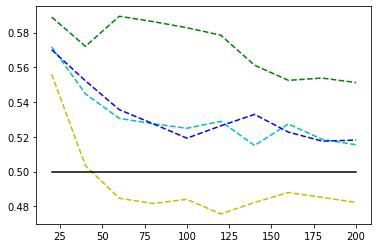

In [74]:
for n in range (20,220,20):
    N = n
    seq = Sequential(n,10)
    resbb = np.sum(np.array([seqgame(seq.blind_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resoo = np.sum(np.array([seqgame(seq.optimal_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    resob = np.sum(np.array([seqgame(seq.optimal_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resbo = np.sum(np.array([seqgame(seq.blind_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    winrates_n_bb[int((n-20)/20)] = resbb/nb_parties
    winrates_n_oo[int((n-20)/20)] = resoo/nb_parties
    winrates_n_ob[int((n-20)/20)] = resob/nb_parties
    winrates_n_bo[int((n-20)/20)] = resbo/nb_parties
    
plt.figure()
plt.plot(ns, winrates_n_bb, 'c--', ns, winrates_n_oo, 'b--', ns, winrates_n_ob, 'g--', ns, winrates_n_bo, 'y--', ns, np.full(ns.shape,0.5),'k')
plt.show()

puis selon le nombre de dés autorisés, en fixant l'objectif N = 100:

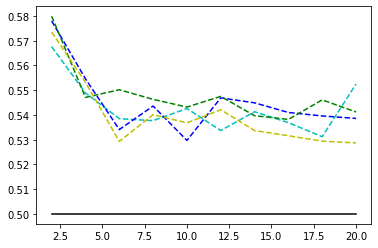

In [92]:
for d in range (2,22,2):
    N = 100
    seq = Sequential(100,d)
    resbb = np.sum(np.array([seqgame(seq.blind_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resoo = np.sum(np.array([seqgame(seq.optimal_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    resob = np.sum(np.array([seqgame(seq.optimal_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resbo = np.sum(np.array([seqgame(seq.blind_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    winrates_d_bb[int((d-2)/2)] = resbb/nb_parties
    winrates_d_oo[int((d-2)/2)] = resoo/nb_parties
    winrates_d_ob[int((d-2)/2)] = resob/nb_parties
    winrates_d_bo[int((d-2)/2)] = resbo/nb_parties

plt.figure()
plt.plot(ds, winrates_d_bb, 'c--', ds, winrates_d_oo, 'b--', ds, winrates_d_ob, 'g--', ds, winrates_d_bo, 'y--', ds, np.full(ns.shape,0.5),'k')
plt.show()

On cherche aussi à évaluer la stratégie aléatoire par rapport aux deux autres : puisqu'on se doute qu'elle va perdre, on lui laisse l'avantage.

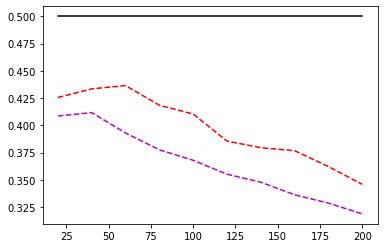

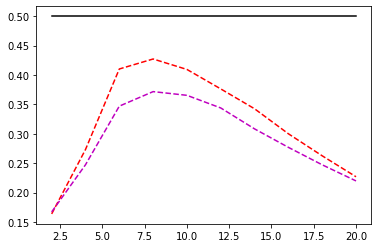

In [14]:
# Aléatoire contre aveugle : mode séquentiel
winrates_n_ab = np.zeros((10))
winrates_d_ab = np.zeros((10))
# Aléatoire contre optimale : mode séquentiel
winrates_n_ao = np.zeros((10))
winrates_d_ao = np.zeros((10))
    
for n in range (20,220,20):
    N = n
    seq = Sequential(n,10)
    resab = np.sum(np.array([seqgame(seq.random_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resao = np.sum(np.array([seqgame(seq.random_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    winrates_n_ab[int((n-20)/20)] = resab/nb_parties
    winrates_n_ao[int((n-20)/20)] = resao/nb_parties

plt.figure()
plt.plot(ns, winrates_n_ab, 'r--', ns, winrates_n_ao, 'm--', ns, np.full(ns.shape,0.5),'k')
plt.show()

In [ ]:
for d in range (2,22,2):
    N = 100
    seq = Sequential(100,d)
    resab = np.sum(np.array([seqgame(seq.random_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    resao = np.sum(np.array([seqgame(seq.random_strategy,seq.optimal_strategy,False) for i in range(nb_parties)]))
    winrates_d_ab[int((d-2)/2)] = resab/nb_parties
    winrates_d_ao[int((d-2)/2)] = resao/nb_parties

plt.figure()
plt.plot(ds, winrates_d_ab, 'r--', ds, winrates_d_ao, 'm--', ds, np.full(ns.shape,0.5),'k')
plt.show()

#### _jeu simultané_

Pour le jeu simultané, on teste comme requis en 14) la solidité de la stratégie pl-optimale face à la stratégie aveugle.  
Il n'y a plus de relation d'ordre entre les joueurs, donc un seul test par paramètre varié suffit pour les comparer.

In [ ]:
# Optimale contre aveugle : mode simultané
winrates_n_plb = np.zeros((10))
winrates_d_plb = np.zeros((10))

for n in range (20,220,20):
    N = n
    seq = Sequential(n,10)
    sim = Simultaneous(n,10)
    resplb = np.sum(np.array([simgame(sim.pl_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    winrates_n_plb[int((n-20)/20)] = resplb/nb_parties
plt.figure()
plt.plot(ns, winrates_n_plb, 'c--', ns, np.full(ns.shape,0.5),'k')
plt.show()

N = 100
for d in range (2,22,2):
    seq = Sequential(N,d)
    sim = Simultaneous(N,d)
    resplb = np.sum(np.array([simgame(sim.pl_strategy,seq.blind_strategy,False) for i in range(nb_parties)]))
    winrates_d_plb[int((d-2)/2)] = resplb/nb_parties
    
plt.figure()
plt.plot(ds, winrates_d_plb, 'c--', ds, np.full(ns.shape,0.5),'k')
plt.show()

# Addenda

Code du programme linéaire pour la onzième question :

In [ ]:
q = np.zeros(D)
q[min(6,D)-1]=1
eg = gain_matrix(D)
eg_q = eg.dot(q)

prob = LpProblem("Détermination de q", LpMaximize)
var = [LpVariable("x%d" % i,lowBound=0,cat='Continuous') for i in range(1,D+1)]

prob += lpSum([var[i]*eg_q[i] for i in range(D)])
prob += lpSum(var) == 1 

prob.solve()
prob.writeLP("prob")

print("Total Optimum=", value(prob.objective)) # doit être nul

for v in prob.variables():
    print(v.name, "=", v.varValue)